In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from mplsoccer import VerticalPitch
import seaborn as sns
import ipywidgets as widgets

#Read data
df = pd.read_csv('Footballdata/New/SouthamptonvsManUtd.csv', encoding='latin-1')

#Change Offside Passes to Passes
df = df.replace('OffsidePass', 'Pass')

#Adjust to pitch
df['x'] = df['x']*1.2
df['y'] = df['y']*.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*.8

#Replacing NaN values
df.endX.fillna(df.x, inplace=True)
df.endY.fillna(df.y, inplace=True)

#remove substitution events,challenges & formation change
df = df.loc[~(df['type/displayName'] == 'SubstitutionOff')]
df = df.loc[~(df['type/displayName'] == 'SubstitutionOn')]
df = df.loc[~(df['type/displayName'] == 'FormationChange')]
df = df.loc[~(df['type/displayName'] == 'Challenge')]
df = df.loc[~(df['type/displayName'] == 'FormationSet')]
df = df.loc[~(df['type/displayName'] == 'Start')]
df = df.loc[~(df['type/displayName'] == 'End')]
df = df.loc[~(df['type/displayName'] == 'Aerial')]
df = df.loc[~(df['type/displayName'] == 'Tackle')]

#remove the records of a failed foul, they should be ignored as their challenges are failed and the shot continues
df = df.loc[~((df['type/displayName'] == 'Foul') & (df['outcomeType/displayName'] == 'Unsuccessful'))]

#remove the records of a corners awarded, they should be ignored as their challenges are failed and the shot continues
df = df.loc[~((df['type/displayName'] == 'CornerAwarded') & (df['outcomeType/displayName'] == 'Unsuccessful'))]

#Taking the variables that are needed
df = df[['expandedMinute', 'teamId','type/displayName','outcomeType/displayName','isTouch',
         'playername','x', 'y', 'endX', 'endY']]

#Combo box, choose team
options = df["teamId"].unique()
options = options.tolist()

options = [x for x in options if str(x) != 'nan']
teamlist = widgets.Combobox(
    placeholder='Enter a team',
    options=options,
    description='Team:',
    ensure_option=True,
    disabled=False
)
teamlist

Combobox(value='', description='Team:', ensure_option=True, options=('Southampton', 'Manchester United'), plac…

In [2]:
#Remove warning
pd.options.mode.chained_assignment = None  # default='warn'

#Filter for ball touches and whether it is a ball recovery
actions = df.loc[(df['isTouch'] == True)
                |(df['type/displayName'] == 'BallRecovery')]

#finding the Recipient of the action/pass made
actions['Recipient'] = actions['playername'].shift(-1)

#finding the next event that occured along with the x & y positions
actions['nextEvent'] = actions['type/displayName'].shift(-1)
actions['x_next'] = actions['x'].shift(-1)
actions['y_next'] = actions['y'].shift(-1)
actions['outcomeType_next'] = actions['outcomeType/displayName'].shift(-1)

#find if the next event is by the same team
actions['teamId_next'] = actions['teamId'].shift(-1)

actions = actions.loc[ (actions['nextEvent'] == 'Pass')
                      |(actions['nextEvent'] == 'TakeOn')
                      |(actions['nextEvent'] == 'Dispossessed')
                      |(actions['nextEvent'] == 'BallRecovery')
                      |(actions['nextEvent'] == 'MissedShots')
                      |(actions['nextEvent'] == 'ShotOnPost')
                      |(actions['nextEvent'] == 'Goal')
                      |(actions['nextEvent'] == 'GoodSkill')
                      |(actions['nextEvent'] == 'SavedShot')
                      |(actions['nextEvent'] == 'BallTouch')
                      |((actions['nextEvent'] == 'Foul') & (actions['outcomeType_next'] == 'Successful'))
                      |((actions['nextEvent'] == 'CornerAwarded') & (actions['outcomeType_next'] == 'Successful'))]


#to calculate the distance between the carried distance, using Euclidean formula
#needs to be more than or equals to a certain value
min_dribble_length = 4
far_enough = (actions['x_next']-actions['endX'])**2 + (actions['y_next'] -actions['endY'])**2 >= min_dribble_length**2

#Check if next team is the same team
same_team = actions['teamId'] == actions['teamId_next']

#filter to find the carries
carries = actions[(far_enough) & (same_team)]

team = teamlist.value
carries = carries.loc [(carries['teamId'] == team)]
carries = carries.reset_index(drop=True)
#carries = carries.loc [(carries['Recipient'] == 'Rodrygo')]

In [3]:
#Import xT Grid/EPVGrid
xT = pd.read_csv("xTGrid.csv", header=None)
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

#Creating Bins
carries['x1_bin'] = pd.cut(carries['endX'], bins=xT_cols, labels=False)
carries['y1_bin'] = pd.cut(carries['endY'], bins=xT_rows, labels=False)
carries['x2_bin'] = pd.cut(carries['x_next'], bins=xT_cols, labels=False)
carries['y2_bin'] = pd.cut(carries['y_next'], bins=xT_rows, labels=False)

carries['start_zone_value'] = carries[['x1_bin', 'y1_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)
carries['end_zone_value'] = carries[['x2_bin', 'y2_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)

# now we find the difference between the start and end to get the xT value
carries['xT'] = carries['end_zone_value'] - carries['start_zone_value']

carries = carries.drop(['expandedMinute','teamId','isTouch'], axis = 1)
#carries

In [4]:
#In the event that you need to accumulate only the positive xT
#carries = carries.loc[carries['xT'] > 0]

#Grouping the players with the sum of their xT's from passes in the game
xTlist = carries.groupby('Recipient').agg({'xT':['sum']})
xTlist.columns = ['xT']
carries = carries.reset_index(drop=True)

#Creating a new dataframe to store everything, to get playername as a variable
new = xTlist['xT'].to_frame(name='SUM').reset_index()
new.columns = ['Player','xT']

#new.drop([0], inplace=True)

#sorting to descending order
new = new.sort_values(by='xT',ascending=False)
#new = new.head(10)

#Round to 4dp
y = new.xT.round(2)

#Only taking the positive xTs as labels
y = y[y>0]
#y

new

,Player,xT
8,Jadon Sancho,0.056584
0,Anthony Elanga,0.040398
4,Cristiano Ronaldo,0.040048
5,David de Gea,0.001638
9,Lisandro Martínez,0.000604
7,Fred,0.000000
11,Raphaël Varane,-0.000653
2,Casemiro,-0.001413
12,Scott McTominay,-0.006510
1,Bruno Fernandes,-0.017309


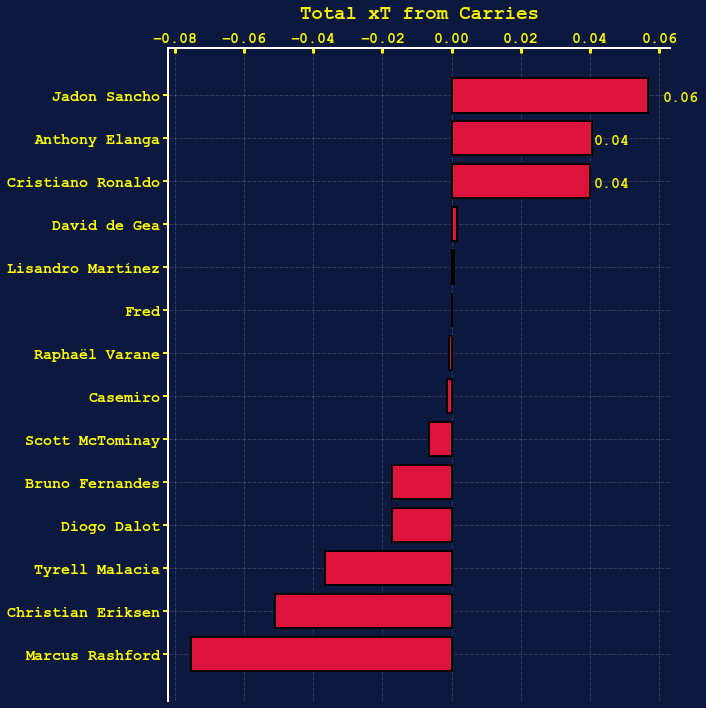

In [6]:
# Figure Size
fig, ax = plt.subplots(figsize=(9,12))
fig.set_facecolor('#0d183f')
#mpl.rcParams['figure.dpi'] = 300

# Horizontal Bar Plot
bar = ax.barh(new.iloc[:,0],new.iloc[:,1], color="crimson", edgecolor='black',lw=2,zorder=3)
ax.set_facecolor('#0d183f')

ax.tick_params(axis='y', colors='yellow')
ax.tick_params(axis='x', colors='yellow')

ax.grid(zorder=0)
    
# Remove axes spines
for s in ['right','bottom']:
    ax.spines[s].set_visible(False)

#Set spine width & color
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['left'].set_color('white')
ax.spines['top'].set_color('white')

# Remove x,y Ticks
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('left')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=3, width=3,length=5,direction='in')
ax.yaxis.set_tick_params(pad=3, width=2,length=5)

# Add x,y gridlines
ax.grid(color='white', linestyle='-.', linewidth=0.5, alpha=0.3)

# Show top values 
ax.invert_yaxis()

# Add Plot Title
ax.set_title("Total xT from Carries",va='center_baseline',
             loc='center', fontsize=19, fontweight='bold', pad=20,
             color='#f5f201',fontfamily='Courier New')

#Setting Plot fonts
font = {'family' : 'Courier New',
        'weight' : 'bold',
        'size' : 15}

mpl.rc('font', **font)

"""# Add Text watermark
fig.text(0.9, 0.13, "@chunhang7\nxT Values from Karun Singh's Model", fontsize=14, color='#f5f201',
         ha='right', va='bottom', alpha=0.5, fontweight='bold', fontfamily='Courier New')
"""
#The values,numbers
for index, value in enumerate(y):
   ax.text(value+.001, index-0.1, str(value), color ='#f5f201',fontweight='bold', ha='left', va='top',fontsize='15')
    
# Show Plot
plt.show()